# Face Recognition: Look How Far We've Come (Part 2)

In this notebook, I continue the computer vision ("CV") solution from Solution 1's canonical Eigenface approach and expolore the Haar Cascades's family of approaches to this classification problem.  

# Solution 2,  The Haar cascade approach

Adapted from my solution to https://github.com/udacity/AIND-CV-FacialKeypoints

In [1]:
# Import the libraries needed for Part 2
import pickle as pkl
import numpy as np
import math
import cv2
import os
import string
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from copy import copy, deepcopy
import operator
from collections import OrderedDict
# The below imports are from haar_helper_functions.py, a set of helper functions
from haar_helper_functions import store_ground_truth, denoise_img, get_face_bound_box, keep_center_face, \
                                  draw_face_with_box, get_left_eye_bound_boxes

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# Reload the directory to the images, allowing for stoppage after Section 1
with open('pic_dir.pickle', 'rb') as picture_path:
    image_3D_dir = pkl.load(picture_path)
    home_dir = pkl.load(picture_path)
    lfw_img_dir= pkl.load(picture_path)
    project_folder = pkl.load(picture_path)
    project_path = pkl.load(picture_path)
    
# Load the funneled 3D images & capture import ground truth data in the process
image_3D_dir_len = len(image_3D_dir)
folders_top_7 = [folder for folder, _, _ in os.walk(image_3D_dir) if len(os.listdir(folder)) >= 70]
del(folders_top_7[0]) # remove the image_3D_dir itself (parent directory/folder without images directly inside it)
name_image_counts = [len(os.listdir(folder)) for folder in folders_top_7]
person_names = [name[image_3D_dir_len:] for name in folders_top_7]
person_indices = np.arange(0,len(person_names))
index_name_dict = {index:name for index,name in zip(person_indices,person_names)}
name_index_dict = {name:index for name,index in zip(person_names, person_indices)}
name_index_dict = sorted(name_index_dict.items(), key=operator.itemgetter(1))
name_index_dict = OrderedDict(name_index_dict)
images_3D_GBR = [cv2.imread(os.path.join(folder_name,file_name)) 
                 for folder_name in folders_top_7 for file_name in os.listdir(folder_name)]
images_3D_RGB = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images_3D_GBR]
images_gray = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images_3D_RGB]
print("The length of image_3D_RGB, the images of the top 7 people, is {}".format(str(len(images_3D_RGB))))

The length of image_3D_RGB, the images of the top 7 people, is 1288


In [3]:
# Load a DataFrame with all information for each picture image
df_ground_truth = store_ground_truth(person_names, name_image_counts)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

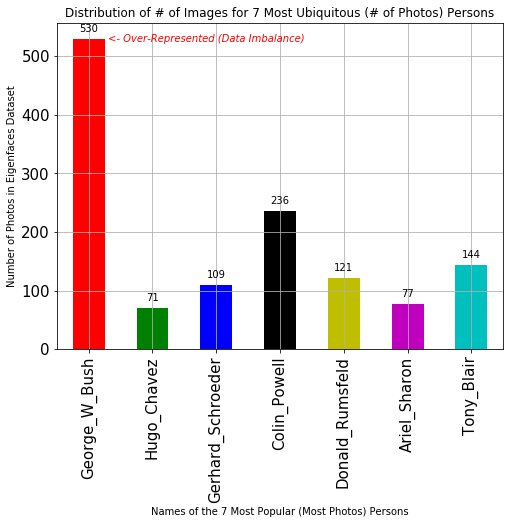

In [4]:
# Plot the data distribution
plt.clf()
column_names = person_names
my_colors = 'rgbkymc'
# Based upon http://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html
df2 = pd.DataFrame([int(y) for y in name_image_counts], [x for x in column_names])
plt.figure()
ax = df2.plot(kind='bar', figsize=(8,6), \
              title='Distribution of # of Images for 7 Most Ubiquitous (# of Photos) Persons', \
              grid=True, stacked=True, color=my_colors, sort_columns=False, legend=False, fontsize=15);
ax.set_xlabel("Names of the 7 Most Popular (Most Photos) Persons")
ax.set_ylabel("Number of Photos in Eigenfaces Dataset")
# From https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=0).astype(int), (p.get_x()+p.get_width()/2.0, 
        p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.text(float(0.3),float(525.0),"<- Over-Represented (Data Imbalance)", style='italic', fontsize=10, color='r')
plt.savefig('top7_distribution.png')

# 2.1 Now, implement & process Haar cascades


In [5]:
# Set some bounding box buffers, if needed, provide a zero_vector if no object found, & instantiate model

# bounding box buffers
buff_px_f = 10 # number of buffering pixels to focus in on the essential facial keypoints
buff_px_e = 0 # number of buffering pixels desired around eye bounding box

# Import the Haar cascade face bounding box model
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Set up zero values in the event a face not found in various data types for flexibility
zero_vector = np.zeros((4,), dtype=int) # in the event that no given body part is found
zero_list =  zero_vector.tolist() # in the event that we need the zero_vector is list form
zero_tuple = tuple(zero_vector) # in the event that we need to store the zero_vector as a tuple

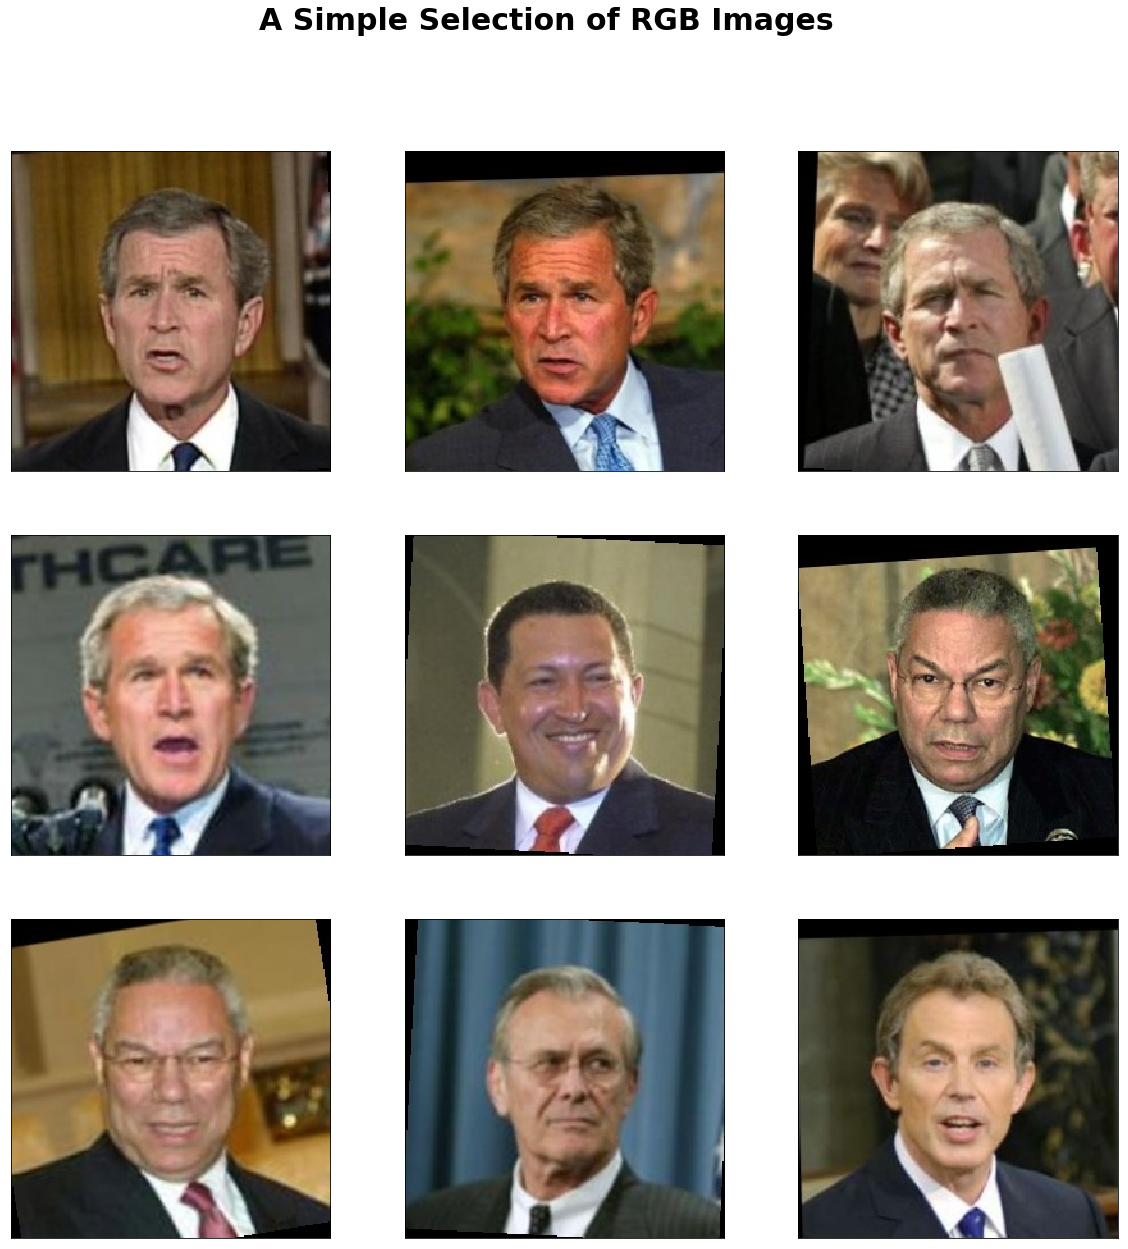

In [6]:
# Let's pick a few images to view
sample_cnt = 9
img_indices = np.arange(0, len(images_3D_RGB), math.ceil(len(images_3D_RGB)/sample_cnt),'uint32').tolist()
images_sample = [images_3D_RGB[img_idx] for img_idx in img_indices]
# For each of the above pictures find the face bounding box
plt.figure(figsize=(20,20))
plt.suptitle('A Simple Selection of RGB Images', fontsize=30, weight='bold')

for i in range(sample_cnt):
    plt.subplot(331 + (i))
    plt.xticks([])
    plt.yticks([])   
    plt.imshow(images_sample[i])

plt.show()

In [7]:
# Let's capture some constants (i.e., picture dimensions & picture center points) & create plotting ticks)
img_dimensions = img_height, img_width, img_colordepth = images_sample[0].shape
print("In this collection, the img_dimensions are {}".format(img_dimensions))

# Capture the center of the image (its 2D coordinates)
img_center_y, img_center_x  = math.floor(img_height/2), math.floor(img_width/2)
img_center_coordinates = [img_center_x, img_center_y ] # switch x-y ordering to avoid later dimensional shifting
print("And the img_center_coordinates are {}".format(img_center_coordinates))

# Now some coordinate axis ticks to see images in relative perspective
x_ticks = np.linspace(0,img_width, dtype=int)
y_ticks = np.linspace(0,img_height, dtype=int)

In this collection, the img_dimensions are (250, 250, 3)
And the img_center_coordinates are [125, 125]


In [8]:
# Let's check for variances in image intensity between classes/persons
avg_px_all = []
i = 0
for count, name in zip(name_image_counts, person_names):
    print('i is {}, and i + count is {}'.format(i, (i+count)))
    person_pics = images_gray[i:(i + count)]
    px_sum = 0
    for pic_idx, pic in enumerate(person_pics):
        px_sum += pic.astype('float64').sum(axis=0).sum()
    px_avg = px_sum/(img_width*img_height*count)
    avg_px_all.append(px_avg)
    i += count

i is 0, and i + count is 530
i is 530, and i + count is 601
i is 601, and i + count is 710
i is 710, and i + count is 946
i is 946, and i + count is 1067
i is 1067, and i + count is 1144
i is 1144, and i + count is 1288


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

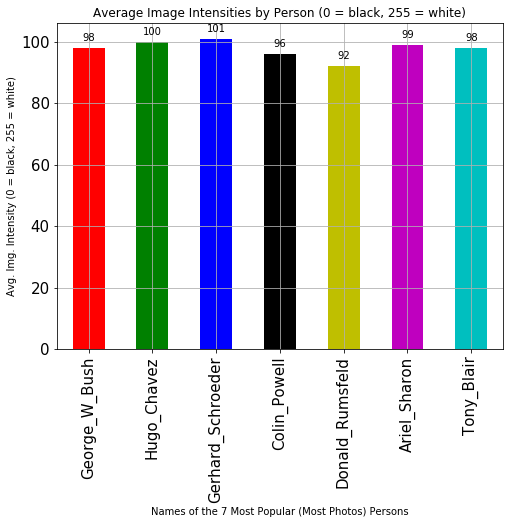

In [9]:
# Now let's graph such intensities

plt.clf()
column_names = person_names
my_colors = 'rgbkymc'
column_values = [int(y) for y in avg_px_all]
# Based upon http://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html
df3 = pd.DataFrame([int(y) for y in avg_px_all], [x for x in column_names])
df3.describe

plt.figure()
ax = df3.plot(kind='bar', figsize=(8,6), \
              title='Average Image Intensities by Person (0 = black, 255 = white)', \
              grid=True, stacked=True, color=my_colors, sort_columns=False, legend=False, fontsize=15);
ax.set_xlabel("Names of the 7 Most Popular (Most Photos) Persons")
ax.set_ylabel("Avg. Img. Intensity (0 = black, 255 = white)")
# From https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=0).astype(int), (p.get_x()+p.get_width()/2.0, 
        p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.savefig('top7_avg_img_intensity.png')

In [10]:
# Let's print summary statistics of the summary dataframe as a last sanity check
df3.describe()

,0
count,7.000000
mean,97.714286
std,2.984085
min,92.000000
25%,97.000000
50%,98.000000
75%,99.500000
max,101.000000


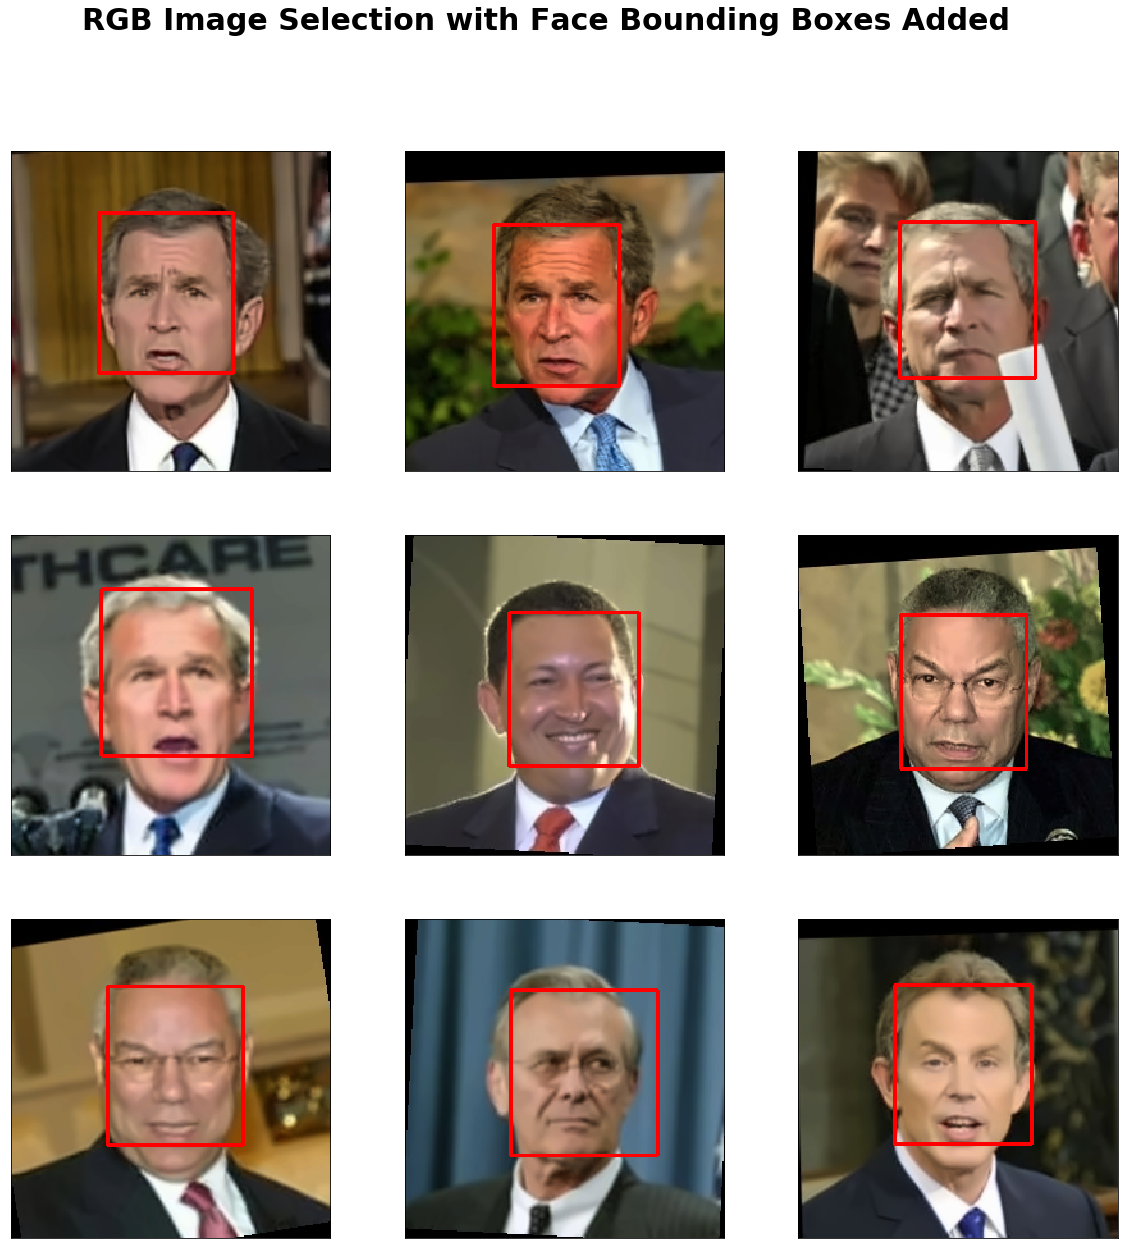

In [11]:
# For each of the above pictures find the face bounding box
images_sample_boxed = []
for img in images_sample:
    img_copy = np.copy(img)
    img_copy = denoise_img(img_copy)
    face_box_coordinates = x_face, y_face, w_face, h_face = get_face_bound_box(img_copy, face_cascade, zero_vector)
    cv2.rectangle(img_copy, (x_face,y_face), (x_face+w_face,y_face+h_face), (255,0,0), 2)
    images_sample_boxed.append(img_copy)

# And now let's see the sample face images so boxed
plt.figure(figsize=(20,20))
plt.suptitle('RGB Image Selection with Face Bounding Boxes Added', fontsize=30, weight='bold')

for i in range(sample_cnt):
    plt.subplot(331 + (i))
    plt.xticks([])
    plt.yticks([])   
    plt.imshow(images_sample_boxed[i])

plt.show()


# Not bad!  For each of the faces the Haar cascade face box was found, cropped, and shows nicel

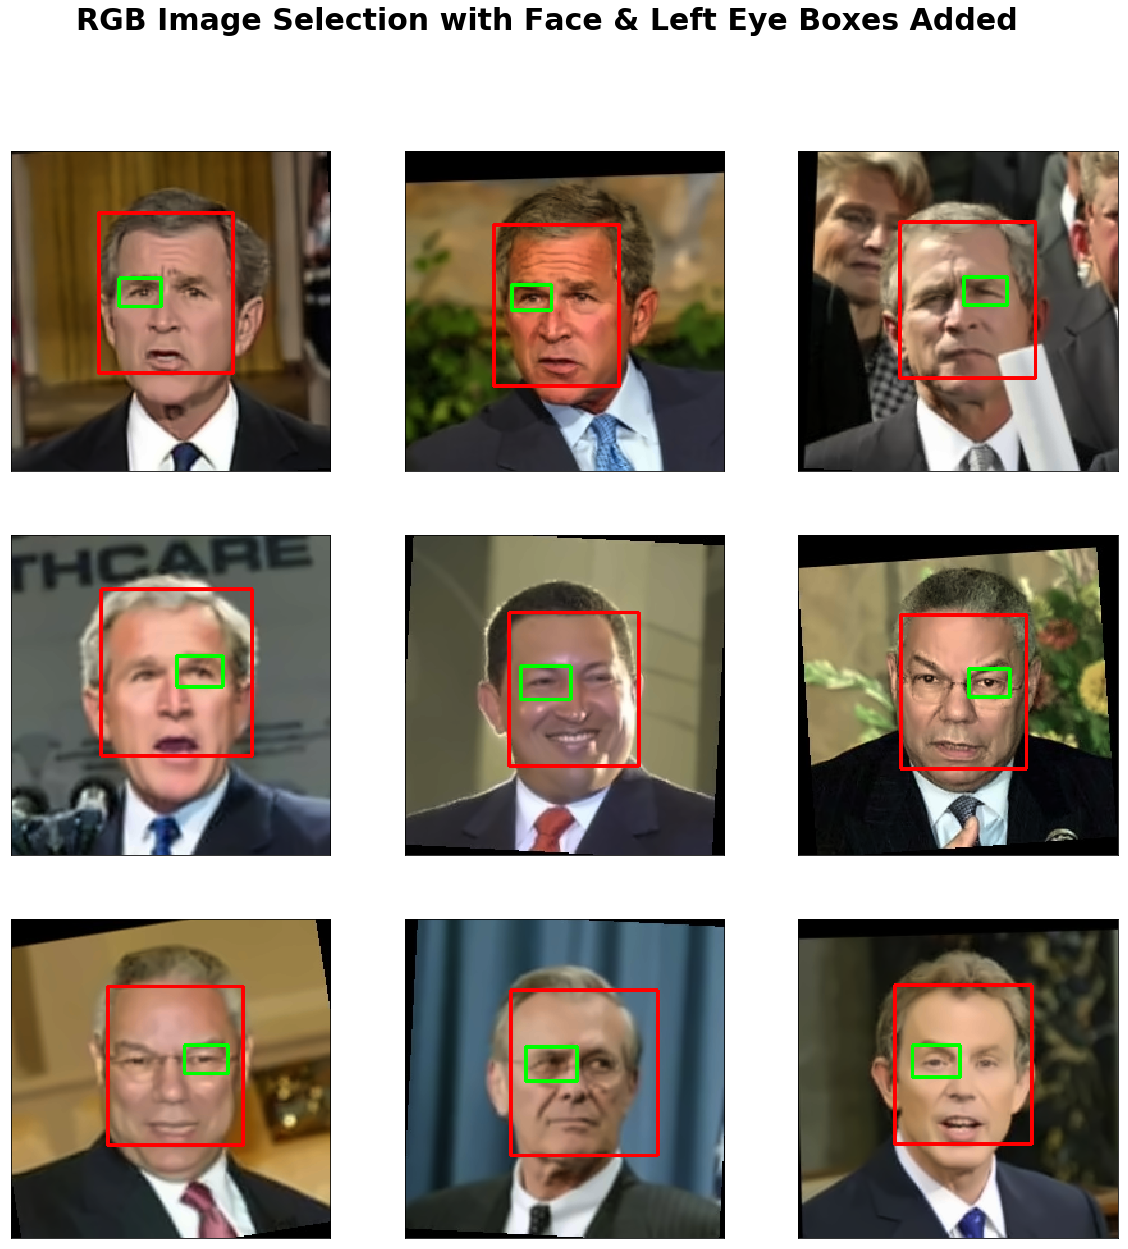

In [12]:
# Instantiate a left eye Haar cascade
eye_cascade_l = cv2.CascadeClassifier('detector_architectures/ojoI.xml')

# Let's find the face & L eye bounding boxes for images_samples
images_sample_face_leye_boxed = []
buff_px_e = 0 # eye bounding box buffer, if needed
for img in images_sample:
    img_copy = np.copy(img)
    img_copy = denoise_img(img_copy)
    face_box_coordinates = x_f, y_f, w_f, h_f = get_face_bound_box(img_copy, face_cascade, zero_vector)
    gray_eye_l = get_left_eye_bound_boxes(img_copy, face_box_coordinates, eye_cascade_l, buff_px_e)
    l_eye_coordinates = x_l_eye, y_l_eye, w_l_eye, h_l_eye = gray_eye_l
    cv2.rectangle(img_copy, (x_f,y_f), (x_f+w_f,y_f+h_f), (255,0,0), 2)
    cv2.rectangle(img_copy, (x_l_eye, y_l_eye), (x_l_eye+w_l_eye,y_l_eye+h_l_eye), (0,255,0), 2)
    images_sample_face_leye_boxed.append(img_copy)

# And now let's see the sample face images so boxed (face and left eye)
plt.figure(figsize=(20,20))
plt.suptitle('RGB Image Selection with Face & Left Eye Boxes Added', fontsize=30, weight='bold')

for i in range(sample_cnt):
    plt.subplot(331 + (i))
    plt.xticks([])
    plt.yticks([])  
    plt.imshow(images_sample_face_leye_boxed[i])
plt.show()

Hmm, problems already.   In order, e.g., to locate a left eye on essentially each person, we set the threshold low for defining an eye detection.   With this fairly high tolerance/low threshold for Donald Rumsfeld, we found only one eye.

For most people, this low threshold results in multiple eye detections, and the best route now avaiable to us is to choose the eye closest to the face bounding box center.   Were we first able to detect the person's nose we would have a proper left eye selection criterion, but that isn't an option - more on that in my report.   

# 2.2.1 And now for something [slightly] different 

The above title - you guessed it - is a pun on the 1971 movie, "And Now for Something Completely Different."   It was based upon the comical television series, Monty Python's Flying Circus.

The above illustrates the results of Haar cascade face and facial part classifiers - that the former (simply finding the region of Interest ("ROI") for a face) works well while the latter (finding facial parts) is not very effective.  Without even a bouding box for key facial keypoints (e.g., around nose) we can't accurately infer other such points (e.g., tip of nose) within a few pixel coordinates.  As such, having found the face we will now endeavor to quantify that ROI with Haar Cascades's sybling implementation, Local Binary Patterns Histograms ("LBPH".)

In [13]:
# Instantiate an LBPH face recognizer
face_recognizer = cv2.face.LBPHFaceRecognizer_create()
# Idea inspired by https://github.com/AbhinavThukral97/FaceRecognition/blob/master/main.py

N.B.:  X directly below is the array/matrix of all data (i.e., grayscale integer for each ROI pixel).  For the time being storing the data in such a 3D array suffices; later, in Solution 3, we will add a 4th spacial dimension (but ignore the temporal one, as these are still images.)  With such fourth dimension, the entire segmented sample spaces (train, validation, and test) can each be thought of as a generalization of these 3D vector fields on differential manifolds mapped to and represented by such rank-4 tensors or, more generally, tensor fields

In [14]:
# Locate a face bounding box for each image and retain that ROI in grayscale as X
X = [] 
for image_RGB in images_3D_RGB: #images_sample  
    img_copy = np.copy(image_RGB)
    img_copy = denoise_img(img_copy)
    face_box_coordinates = x_f, y_f, w_f, h_f = get_face_bound_box(img_copy, face_cascade, zero_vector)
    img_gray = cv2.cvtColor(img_copy, cv2.COLOR_RGB2GRAY)
    if x_f == 0 and y_f == 0 and w_f == 0 and h_f == 0:
        image_boxed = img_gray[0:0+img_height, 0:0+img_width]
    else:
        image_boxed = img_gray[y_f:y_f+h_f, x_f:x_f+w_f]
    X.append(image_boxed)

In [15]:
# Split the data and train the model
y_list = df_ground_truth['person_idx'].tolist()
y_list_RGB = df_ground_truth['person_idx'].tolist()
y_names = df_ground_truth['person_name'].tolist()
y_names_RGB = df_ground_truth['person_name'].tolist()
X_RGB = images_3D_RGB # X_RGB just another pointer to same list on RHS but clear & concise bifurcation below

y = np.array(y_list)
y_RGB = np.array(y_list_RGB)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train_RGB, X_test_RGB, y_train_RGB, y_test_RGB = train_test_split(X_RGB, y_list_RGB, test_size=0.2, random_state=123)
print("About to train")
face_recognizer.train(X_train, y_train)
print("Finished training & about to write")
face_recognizer.write('LBPHmodel.yml')
print("Finished writing")

About to train
Finished training & about to write
Finished writing


In [16]:
# Make predictions from the test set & compare to actual labels
face_recognizer.read('LBPHmodel.yml')
y_preds = []
for image_t in X_test:
    y_pred, _ = face_recognizer.predict(np.array(image_t, 'uint8'))
    y_preds.append(y_pred)

In [17]:
#Capture target values of y_test both as integers and as names (strings)
y_test_int = [int(y_t) for y_t in y_test]
target_names = [person_names[i] for i in y_test]

In [18]:
# Quantitative evaluation of the model quality on the test set
n_classes = len(person_names)
print("Predicting people's names on the test set with the LBPH Face Classifier")

print(classification_report(y_test_int, y_preds, target_names=person_names))
print(confusion_matrix(y_test_int, y_preds, labels=range(n_classes)))

Predicting people's names on the test set with the LBPH Face Classifier
                   precision    recall  f1-score   support

    George_W_Bush       0.96      0.95      0.95       115
      Hugo_Chavez       1.00      0.83      0.91        12
Gerhard_Schroeder       0.96      0.79      0.87        33
     Colin_Powell       0.95      0.95      0.95        37
  Donald_Rumsfeld       0.72      0.96      0.82        24
     Ariel_Sharon       1.00      0.94      0.97        18
       Tony_Blair       0.81      0.89      0.85        19

      avg / total       0.93      0.92      0.92       258

[[109   0   0   2   3   0   1]
 [  0  10   0   0   0   0   2]
 [  4   0  26   0   2   0   1]
 [  0   0   0  35   2   0   0]
 [  1   0   0   0  23   0   0]
 [  0   0   0   0   1  17   0]
 [  0   0   1   0   1   0  17]]


# Voila, using Haar Cascades-LBPH classification, has resulted in precision in facial matching better than that for PCA-SVM on the same portion of the Eigenfaces dataset.

In [19]:
# Let's persist some data to file to use separately in Section 3, if needed
with open('images_3D_RGB_top7.pickle', 'wb') as picture_pickle:
    pkl.dump(images_3D_RGB, picture_pickle, protocol=pkl.HIGHEST_PROTOCOL)
with open('df_ground_truth.pickle', 'wb') as ground_truth_pickle:
    pkl.dump(df_ground_truth, ground_truth_pickle, protocol=pkl.HIGHEST_PROTOCOL)
with open('testing_data.pickle', 'wb') as testing_data_pickle:
    pkl.dump(X_train_RGB, testing_data_pickle, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(X_test_RGB, testing_data_pickle, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(y_train_RGB, testing_data_pickle, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(y_test_RGB, testing_data_pickle, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(y_test_int, testing_data_pickle, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(target_names, testing_data_pickle, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(n_classes, testing_data_pickle, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(name_image_counts, testing_data_pickle, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(person_names, testing_data_pickle, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(index_name_dict, testing_data_pickle, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(name_index_dict, testing_data_pickle, protocol=pkl.HIGHEST_PROTOCOL)
with open('haar_objects.pickle', 'wb') as haar_data:
     pkl.dump(zero_vector, haar_data, protocol=pkl.HIGHEST_PROTOCOL)

# On to Solution 3 (Part 3), a Trial Application of Deep Learning (dl_face_sol3.ipynb)